In [3]:
include("../../startup.jl")
using DifferentialEquations
using NumericallyIntegrateArrays
using Distributions
using LaTeXStrings
using LsqFit
using Interpolations
using JLD2
using JuliaDB

In [4]:
default(size=(600,400), grid=false, linewidth=2,
    tickfontsize=18, guidefontsize=18, legendfontsize=16, titlefontsize=20, margin=10mm)

In [5]:
@load "radiotrack.jld2" t meansd semsd stdsd
t_rt = t 
msd_rt = meansd;
sem_rt = semsd;
std_rt = stdsd;

Diffusion simulations in one and two dimensions:

In [266]:
function convectiondiffusions!(du,u,p,t)
    d,n,c = p
    du[1] = d*(u[2]-u[1]) - c*(u[2])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1]) - c*(u[i+1]-u[i])
    end
    du[n] = d*(u[n-1]-u[n]) + c*(u[n])
end

function convection_diffusion_sim(d1, d2, c, dt, u0, N, t, tD, x)
    tspan = (0.0, dt)
    u_int = [trapz(u0,dx)]
    u0s = [u0]
    msd = [trapz(u0.*x.^2,dx)]
    for (i,ts) in enumerate(t[1:end-1]) 
        if ts < tD
            prob = ODEProblem(diffusions!,u0,tspan,(d1,N))
            u0 = solve(prob).u[end]
        else
            prob = ODEProblem(convectiondiffusions!,u0,tspan,(d2,N,c))
            u0 = solve(prob).u[end]
        end 
        append!(u0s, [u0])
        append!(msd,trapz(u0.*x.^2,dx))
        append!(u_int,trapz(u0,dx))
    end
    return msd, u0s, u_int
end

function convectiondiffusions2d!(du,u,p,t)
    d,n,c,r_exp,dx = p
    du[1] = d*(u[2]-u[1]) + (d/2)*(u[2]-u[1]) - (c*dx^r_exp)*(u[2])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1]) + (d/2i)*(u[i+1]-u[i-1]) - (c*(i*dx)^r_exp/i)*(u[i+1]-u[i])
    end
    du[n] = d*(u[n-1]-u[n]) + (d/2n)*(u[n]-u[n-1]) + (c*(dx*n)^r_exp/n)*(u[n])
end

function convection_diffusion_sim2d(d, c, dt, u0, N, t, tD,r_exp,dx)
    tspan = (0.0, dt)
    u0s = [u0]
    msd = [dx*2*pi*sum(u0.*r.^3)]
    us_int = [dx*2*pi*sum(r.*u0)*dx]
    for (i,ts) in enumerate(t[1:end-1]) 
        if ts < tD
            prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,N,0,0,dx))
            u0 = solve(prob).u[end]
        else
            prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,N,c,r_exp,dx))
            u0 = solve(prob).u[end]
        end 
        append!(u0s, [u0])
        append!(msd,dx*2*pi*sum(u0.*r.^3)) 
        append!(us_int,dx*2*pi*sum(u0.*r))
    end
    return msd, u0s, us_int
end

convection_diffusion_sim2d (generic function with 2 methods)

In [317]:
chi = c*dx

50000.0

In [318]:
string(L"\chi=",c*dx,L", r=",r_exp)

"\$\\chi=\$50000.0\$, r=\$-2.0"

In [321]:
L"\chi=%$(c*dx), \beta=%$r_exp"

L"$\chi=50000.0, \beta=-2.0$"

In [340]:
T = 15*3600.
pgfplotsx()

c= -2.
r_exp = 0.
msd = []
ts = []
tspan = (0,tD*2)
prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,N,0,0,dx));
solution = solve(prob)
for (t,us) in zip(solution.t,solution.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
tspan = (tD*2,T)
prob = ODEProblem(convectiondiffusions2d!,solution.u[end],tspan,(d,N,c,r_exp,dx))
solution2 = solve(prob,Rosenbrock23(),dtmax=100);
for (t,us) in zip(solution2.t,solution2.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
plot(ts./3600,msd./1e6,label=L"\chi_0=%$(c*dx), \beta=%$r_exp",color=lc[1],ls=ls[1])

c= -0.001
r_exp = 1.
msd = []
ts = []
tspan = (0,tD*2)
prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,N,0,0,dx));
solution = solve(prob)
for (t,us) in zip(solution.t,solution.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
tspan = (tD*2,T)
prob = ODEProblem(convectiondiffusions2d!,solution.u[end],tspan,(d,N,c,r_exp,dx))
solution = solve(prob,Rosenbrock23(),dtmax=100);
for (t,us) in zip(solution.t,solution.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
plot!(ts./3600,msd./1e6,label=L"\chi_0=%$(c*dx), \beta=%$r_exp",color=lc[2],ls=ls[2])


c= -0.000001
r_exp = 2.
msd = []
ts = []
tspan = (0,tD*2)
prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,N,0,0,dx));
solution = solve(prob)
for (t,us) in zip(solution.t,solution.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
tspan = (tD*2,T)
prob = ODEProblem(convectiondiffusions2d!,solution.u[end],tspan,(d,N,c,r_exp,dx))
solution = solve(prob,Rosenbrock23(),dtmax=100);
for (t,us) in zip(solution.t,solution.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
plot!(ts./3600,msd./1e6,label=L"\chi_0=-1\times 10^{-5}, \beta=%$r_exp",color=lc[3],ls=ls[2])

c= 200.
r_exp = -1.
msd = []
ts = []
tspan = (0,tD*2)
prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,N,0,0,dx));
solution = solve(prob)
for (t,us) in zip(solution.t,solution.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
tspan = (tD*2,T)
prob = ODEProblem(convectiondiffusions2d!,solution.u[end],tspan,(d,N,c,r_exp,dx))
solution = solve(prob,Rosenbrock23(),dtmax=100);
for (t,us) in zip(solution.t,solution.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
plot!(ts./3600,msd./1e6,label=L"\chi_0=%$(c*dx), \beta=%$r_exp",color=lc[4],ls=ls[3])

c= 5000.
r_exp = -2.
msd = []
ts = []
tspan = (0,tD*2)
prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,N,0,0,dx));
solution = solve(prob)
for (t,us) in zip(solution.t,solution.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
tspan = (tD*2,T)
prob = ODEProblem(convectiondiffusions2d!,solution.u[end],tspan,(d,N,c,r_exp,dx))
solution = solve(prob,Rosenbrock23(),dtmax=100);
for (t,us) in zip(solution.t,solution.u)
    append!(ts,t)
    append!(msd,dx*2*pi*sum(us.*r.^3))
end
plot!(ts./3600,msd./1e6,label=L"\chi_0=%$(c*dx), \beta=%$r_exp",color=lc[5],ls=ls[3])

plot!(xlabel="Time (hours)",ylabel=L"\mathrm{MSD (km^2)}",legend=:outertopright)
savefig("../figs/rdependentphi.png")

In [12]:
L = 2000
N = 200
dx = L/N
D = 100
d = D/dx^2
u = zeros(N)
T = 3600*8
tD=0
dt = (0.5*dx^2/2D)#1 
t = dt:dt:T
r = dx:dx:L
u0 = zeros(size(r))
u0[1] = 1/(2*pi*dx^2) #/2 because using the sum to integrate, we want the average 
u01 = zeros(size(r))
u01[1] = 1/dx
tspan = (0.0, dt)

msd_diff,u2d, u_int2d  =  convection_diffusion_sim2d(d, 0, dt, u0, N, t, tD,0,dx);
msd_diff1d,u1d, u_int1d = convection_diffusion_sim(d, d, 0, dt, u01, N, t, tD, r)

asymptote2d = collect(dt:dt:T) 
asymptote2d.= maximum(msd_diff)
asymptote1d = collect(dt:dt:T)
asymptote1d.= maximum(msd_diff1d);

pgfplotsx()
p1 = plot(xlabel="Time (hours)", ylabel=L"MSD (km^2)",ylims=[0,maximum(msd_diff)./10^6])
plot!((dt:dt:T)./3600,msd_diff1d./10^6, label="1D Diffusion Simulation", ls=ls[1],color=lc[2])
plot!((dt:dt:T)./3600,msd_diff./10^6, label="2D Diffusion Simulation", ls=ls[1],color=lc[4])
plot!((dt:dt:T)./3600,2D*(dt:dt:T)./10^6, label=L"2Dt", ls=ls[2],color=lc[2])
plot!((dt:dt:T)./3600,4D*(dt:dt:T)./10^6, label=L"4Dt", ls=ls[2],color=lc[4])
plot!((dt:dt:T)./3600,asymptote2d./10^6, label="", ls=ls[3],color=lc[1], linewidth=1)
plot!((dt:dt:T)./3600,asymptote1d./10^6, label="", ls=ls[3],color=lc[1], linewidth=1)
#savefig("../figs/1d2d_diffusion.png")

In [39]:
t = collect(dt:dt:T)
uR2d = zeros(length(t))
uR1d = zeros(length(t))
for (i,ts) in enumerate(t)
    uR2d[i] = u2d[i][end]
    uR1d[i] = u1d[i][end]
end
expectedmsd2d = zeros(length(t))
expectedmsd1d = zeros(length(t))
for (i,ts) in enumerate(t)
    expectedmsd2d[i] = 4D*(ts - π*L^2 * trapz(uR2d[1:i],t[1:i]))
    expectedmsd1d[i] = 2D*(ts - L*trapz(uR1d[1:i],t[1:i]))
end

pgfplotsx()
bigdt = 100:100:t[end]
asymptote = zeros(length(bigdt))
asymptote.= L^2/2e6
plot(xlabel=L"t \mathrm{(hours)}",ylabel=L"MSD \mathrm{ (km^2)}",ylims=(0,(L^2/2e6).*1.1),legend=:outerright)
plot!(t./3600,expectedmsd2d./1e6,ls=ls[1],color=lc[1], label=L"4D\left(t-\int_0^t 4\pi DR^2\phi(R,\tau)d\tau\right)")
plot!(bigdt./3600,(4D.*bigdt)./1e6,label=L"4Dt",ls=ls[2],color=lc[2])
plot!(bigdt./3600,asymptote,label=L"R^2/3",ls=ls[2],color=lc[4])
scatter!(t[4000:4000:end]./3600,msd_diff[4000:4000:end]./1e6,label=L"\int_0^{2\pi} \int_0^{R} r^3 \phi(r,t)dr",ls=ls[3],color=lc[3])
savefig("../figs/expectedmsd2d.png")

bigdt = 100:100:t[end]
asymptote = zeros(length(bigdt))
asymptote.= L^2/3e6
plot(xlabel=L"t \mathrm{(hours)}",ylabel=L"MSD \mathrm{ (km^2)}",ylims=(0,L^2/3e6),legend=:bottomright)
plot!(t./3600,expectedmsd1d./1e6, label=L"2D(t-\int_0^t R\phi(R,\tau)d\tau)",ls=ls[1],color=lc[1])
plot!(bigdt./3600,(2D.*bigdt)./1e6,label=L"2Dt",ls=ls[2],color=lc[2])
plot!(bigdt./3600,asymptote,label=L"R^2/3",ls=ls[2],color=lc[4])
scatter!(t[4000:4000:end]./3600,msd_diff1d[4000:4000:end]./1e6,label=L"\int_0^{R} x^2 \phi(x,t)dx",color=lc[3])
savefig("../figs/expectedmsd1d.png")

In [45]:
plot(xlabel=L"$r$(m)", ylabel=L"\phi")
i = 1
 plot!(u[Int(div(3600*i,dt))],label=L"$t=1$ hour",ls=ls[i],color=lc[i])
i = 2
    plot!(u[Int(div(3600*i,dt))],label=L"$t=2$ hours",ls=ls[i],color=lc[i])
i = 3
 plot!(u[Int(div(3600*i,dt))],label=L"$t=3$ hours",ls=ls[i],color=lc[i])
i = 5
 plot!(u[Int(div(3600*i,dt))],label=L"$t=5$ hours",ls=ls[i],color=lc[i])
plot!()
savefig("../figs/discretised_phi.png")

Diffusion simulation on a 2D shrinking domain:

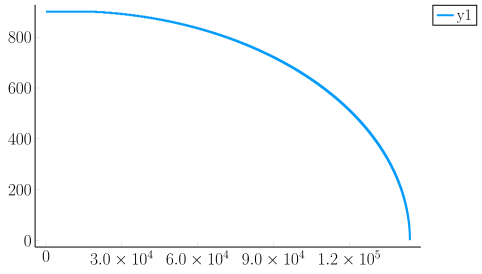

In [232]:
θ = [t_s,R_0]
boxsize = zeros(Int, size(t))
    boxsize[t .<= θ[2]] .= div(θ[1],dx)
    boxsize[t .> θ[2]] .= Int.(ceil.(shrink_rate(t[t .> θ[2]].-θ[2],θ[1])./dx))
    boxsize[boxsize.>div(θ[1],dx)] .= div(θ[1],dx)
    boxsize[boxsize .== 1] .= 2
    boxsize[end] = 1
plot(boxsize.*dx)

In [206]:
function shrink_rate(ts,R0 )
    a = R0^2 ./ts[end]^2
    Rt2 = R0^2 .- a.*ts.^2
    Rt2[Rt2.<0] .= 0.0
    return sqrt.(Rt2)
end

function domain_shrink2d(θ, D, dt,u0, N, dx, t, tD, r)
    boxsize = zeros(Int, size(t))
    boxsize[t .<= θ[2]] .= div(θ[1],dx)
    boxsize[t .> θ[2]] .= Int.(ceil.(shrink_rate(t[t .> θ[2]].-θ[2],θ[1])./dx))
    boxsize[boxsize.>div(θ[1],dx)] .= div(θ[1],dx)
    boxsize[boxsize .== 1] .= 2
    boxsize[end] = 1
    tspan = (0.0, dt)
    msd = [2*pi*sum(u0.*r.^3)]
    us_int = [2*pi*sum(r.*u0)]
    for (i,ts) in enumerate(t[1:end-1])
        if ts > tD
            ns = length(u0)
            prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,ns,c))
            u0 = solve(prob, Euler(),dt=dt).u[end]
        end
        if ts > tD
            if boxsize[i+1] < length(u0) && boxsize[i+1] < boxsize[i]
                u0[boxsize[i+1]] += sum(u0[boxsize[i+1]+1:end])
                u0 = u0[1:boxsize[i+1]]
                r = r[1:boxsize[i+1]]
            end
        end 
        append!(msd,2*pi*sum(u0.*r.^3))
        append!(us_int,2*pi*sum(u0.*r))
    end
    return msd, us_int
end


function r2_test(x1,y1,x_model,y_model)
    sstot = 0 
    ssres = 0
    for (i,xi) in enumerate(x1)
        sstot += (y1[i]-mean(y1))^2
        ssres +=  (y_model[findfirst(x -> x==xi, x_model)]-y1[i])^2
    end 
    return 1 - ssres/sstot
end

r2_test (generic function with 1 method)

Parameter sweep over possible R_0 and t_ss values:

In [207]:
N = 200
D = 65
T = t_rt[end-6]
tD = 600.0

R_0s = 1200:50:1800
t_ss = 0:1000:5000

r2 = zeros(length(R_0s),length(t_ss))
    
@time for (i,R_0) in enumerate(R_0s)
    for (j,t_s) in enumerate(t_ss)
        dx = R_0/N
        dt = (0.9dx^2/2D)
        r = dx:dx:R_0    
        u0 = zeros(size(r))
        u0[1] = 1/(2*pi*dx)
        T = t_rt[end]+dt
        t = dt:dt:T
        msds, u_int = domain_shrink2d([R_0,t_s], D, dt,u0, N, dx, t, tD, r);
        itp = interpolate((t,), msds, Gridded(Linear()))
        msd_itp = [ itp(ts) for ts in t_rt]
        r2[i,j] = r2_test(t_rt,msd_rt,t_rt,msd_itp)
    end
end

@save "test.jld2" R_0s t_ss r2;

656.158399 seconds (2.34 G allocations: 226.423 GiB, 7.48% gc time)


Load test values and plot parameter sweep and best solution:

In [6]:
@load "test.jld2" R_0s t_ss r2
R_0 = R_0s[findmax(r2)[2][1]] 
t_s = t_ss[findmax(r2)[2][2]]
R_0, t_s

pgfplotsx()
#r2s = r2
#r2s[r2s.<0.8] .= 0.8
R_0 = R_0s[findmax(r2)[2][1]] 
t_s = t_ss[findmax(r2)[2][2]]
p1 = plot(size=(300,200), grid=false, linewidth=2,
    tickfontsize=10, guidefontsize=10, legendfontsize=10, titlefontsize=10, margin=10mm)
heatmap!(R_0s, t_ss, r2', match_dimensions=true, xlabel=L"R_0",ylabel=L"t_s", colorbar_title=L"$R^2$ value", label=L"$R^2$ value")#,colorbar_titlefontsize=12)
scatter!([R_0,R_0],[t_s,t_s], label="", marker=:xcross, markersize=8, color=:black)
#savefig("../figs/2dshrink_sweep.png")

R_0 = R_0s[findmax(r2)[2][1]] 
t_s = t_ss[findmax(r2)[2][2]]

dx = R_0/N
dt = (0.8dx^2/2D)
r = dx:dx:R_0      
u0 = zeros(size(r))
u0[1] = 1/(2*pi*dx)
t = dt:dt:T
msds, u_int = domain_shrink2d([R_0,t_s], D, dt,u0, N, dx, t, tD, r); 
p2 = plot(xlabel="Time (hours)", ylabel=L"MSD (m^2)", legend=:topright)
plot!(t[100:1000:end]./3600,msds[100:1000:end], color=:blue, label="Shrinking diffusion")
scatter!(t_rt./3600,msd_rt, color=:red, label="Radiotracking data")
plot!(t_rt./3600,msd_rt, ribbon=sem_rt, fill=:orange, linewidth=0,
    markersize=8, color=:orange, label="Standard error")
#savefig("../figs/2dshrink_result.png")

UndefVarError: UndefVarError: D not defined

Convection-diffusion simulations:

In [7]:

function convectiondiffusions2d!(du,u,p,t)
    d,n,c,r_exp,dx = p
    du[1] = d*(u[2]-u[1]) + (d/2)*(u[2]-u[1]) - (dx)^r_exp*c*(u[2])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1]) + (d/2i)*(u[i+1]-u[i-1]) - (i*dx)^r_exp*(c/i)*(u[i+1]-u[i])
    end
    du[n] = d*(u[n-1]-u[n]) + (d/2n)*(u[n]-u[n-1]) + (n*dx)^r_exp*(c/n)*(u[n])
end

function convection_diffusion_sim2d(d, c, dt, u0, N, t, tD,r_exp,dx)
    tspan = (0.0, dt)
    u0s = [u0]
    msd = [2*pi*sum(u0.*r.^3)]
    us_int = [2*pi*sum(r.*u0)]
    for (i,ts) in enumerate(t[1:end-1]) 
        if ts < tD
            prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,N,0,r_exp,dx))
            u0 = solve(prob).u[end]
        else
            prob = ODEProblem(convectiondiffusions2d!,u0,tspan,(d,N,c,r_exp,dx))
            u0 = solve(prob).u[end]
        end 
        append!(u0s, [u0])
        append!(msd,2*pi*sum(u0.*r.^3))
        append!(us_int,2*pi*sum(u0.*r))
    end
    return msd, u0s, us_int
end

convection_diffusion_sim2d (generic function with 1 method)

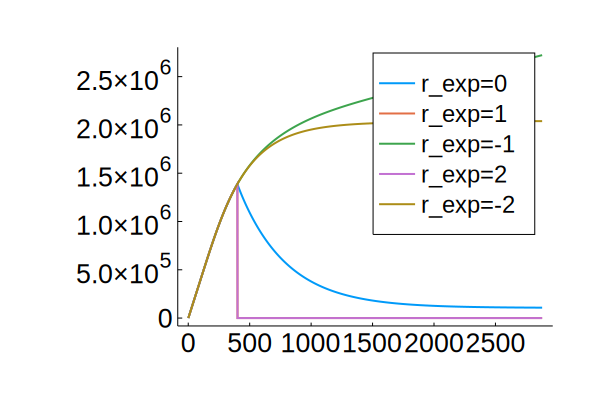

In [8]:
L = 2000
N = 100
dx = div(L,N)
D1 = 100
d1 = D1/dx^2
u = zeros(N)
tD = 4000
T = 3600*8
dt = 10.0
chi = - 15
c = chi/dx
r = dx:dx:L
u0 = zeros(size(r))
u0[1] = 1/(2*pi*dx)
tspan = (0.0, dt)
t = dt:dt:T
gr()
r_exp = 0
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c, dt, u0, N, t, tD,r_exp,dx)
plot(msd_cd,label="r_exp=0")
r_exp = 1.
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c, dt, u0, N, t, tD,r_exp,dx)
plot!(msd_cd,label="r_exp=1")
r_exp = -1.
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c, dt, u0, N, t, tD,r_exp,dx)
plot!(msd_cd,label="r_exp=-1")
r_exp = 2.
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c, dt, u0, N, t, tD,r_exp,dx)
plot!(msd_cd,label="r_exp=2")
r_exp = -2.
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c, dt, u0, N, t, tD,r_exp,dx)
plot!(msd_cd,label="r_exp=-2")

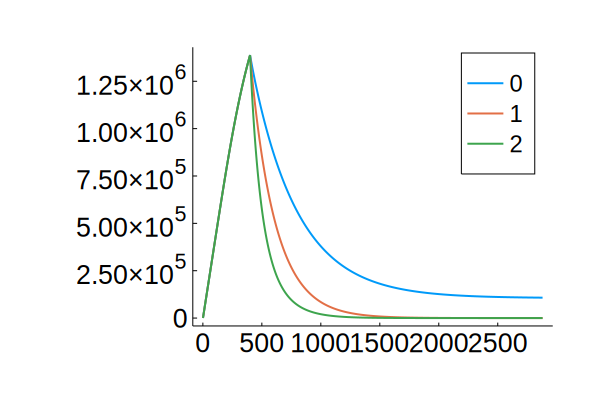

In [9]:
r_exp = 0
plot(legend=:outertopright)
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c, dt, u0, N, t, tD,r_exp,dx)
plot(msd_cd,label="0")
r_exp = 1.
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c/1e3, dt, u0, N, t, tD,r_exp,dx)
plot!(msd_cd,label="1")
r_exp = 2.
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c/1e6, dt, u0, N, t, tD,r_exp,dx)
plot!(msd_cd,label="2")

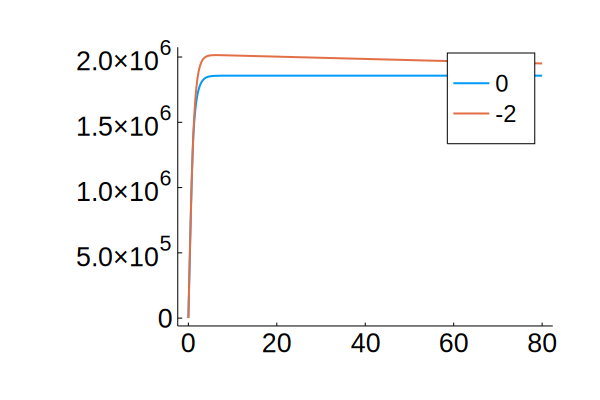

In [44]:
t = dt:dt:T*10
r_exp = 0
plot(legend=:outertopright)
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c./10, dt, u0, N, t, tD,r_exp,dx)
plot(t./3600,msd_cd,label="0")
r_exp = -2.
msd_cd, u, u_int = convection_diffusion_sim2d(d1, 2500, dt, u0, N, t, tD,r_exp,dx)
plot!(t./3600,msd_cd,label="-2")

In [47]:
r_exp = -2.
msd_cd, u, u_int = convection_diffusion_sim2d(d1, 50000, dt, u0, N, t, tD,r_exp,dx)
plot!(t./3600,msd_cd,label="-2")

In [154]:
L = 2000
N = 100
dx = div(L,N)
D1 = 100
d1 = D1/dx^2
u = zeros(N)
tD = 4000
T = 3600*8
dt = 10.0
chi = - 15
c = chi/dx
r = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/(2*pi*dx)
tspan = (0.0, dt)
t = dt:dt:T
msd_cd, u, u_int = convection_diffusion_sim2d(d1, c, dt, u0, N, t, tD);
plot(xlabel=L"$r$(m)", ylabel=L"\phi")
i = 1
 plot!(r,u[Int(div(3600,dt))],label=L"$t=1$ hour",ls=ls[i],color=lc[i])
i = 2
    plot!(r,u[Int(div(3600*2,dt))],label=L"$t=2$ hours",ls=ls[i],color=lc[i])
i = 3
 plot!(r,u[Int(div(3600*3,dt))],label=L"$t=3$ hours",ls=ls[1],color=lc[i])
i = 5
 plot!(r,u[Int(div(3600*5,dt))],label=L"$t=5$ hours",ls=ls[2],color=lc[i])
plot!(yaxis=:log,     tickfontsize=20, guidefontsize=20, legendfontsize=20,legend=:topright)
savefig("../figs/convection_diffusion_phi2dchi_15.png")
p1 = plot(xlabel="Time (hours)", ylabel=L"MSD (m$^2$)",legend=:bottomright)
plot!(t./3600, msd_cd, label="",ls=ls[1],color=lc[2],     tickfontsize=20, guidefontsize=20, legendfontsize=20)
savefig("../figs/convection_diffusion_MSD2dchi_15.png")

DimensionMismatch: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 1000 and 100")

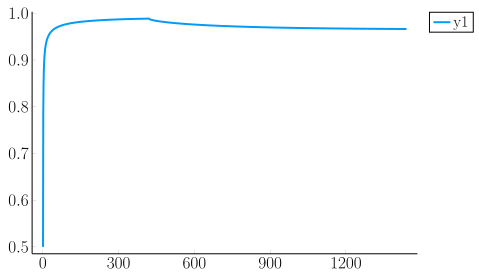

In [177]:
L = 2000
N = 100
dx = div(L,N)
D1 = 63.4
d1 =D1/dx^2
u = zeros(N)
tD = 4200
T = 3600*4
dt = 10.0
D2 = 40.0
d2 = D2/dx^2
chi = - 0.15
c = chi/dx
#IC is solution to diffusion equation at time T

x = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/dx
tspan = (0.0, dt)

#msd_diff =  diffusion_sim(d1, dt, u0, N, dt:dt:T)
msd_cd,u0s, u_int = convection_diffusion_sim(d1, d2, c, dt, u0, N,dt:dt:T, tD, r)
t_cd = dt:dt:T
#convection_diffusion_sim(d, d, 0, dt, u01, N, t, tD, r)
#plot(xlabel=xlabel=L"$t$ (hours)", ylabel=L"MSD (km$^2$)")
#plot!((dt:dt:T)./3600,msd_cd./1e6,label="", linewidth=2)
#savefig("../figs/convection_diffusion_MSD.png")
plot(u_int)

In [113]:
plot(xlabel=L"$r$ (m)",ylabel=L"\phi")
plot!(u0s[360],label=L"$t = 0$ hours")
plot!(u0s[360+72],label=L"$t = 0.2$ hours")
#plot!(u0s[360+180],label=L"$t = 0.5$ hours")
plot!(u0s[360+2*360],label=L"$t = 2$ hours")
plot!(u0s[2880],label=L"$t = 8$ hours")
savefig("../figs/convection_diffusion.png")

In [118]:
function shrink_rate(ts,R0 )
    a = R0^2 ./ts[end]^2
    Rt2 = R0^2 .- a.*ts.^2
    Rt2[Rt2.<0] .= 0.0
    return sqrt.(Rt2)
end

function domain_shrink(θ, d, dt,u0, t, tD)
    u0s = [u0]
    boxsize = zeros(Int, size(t))
    #print("t_rt = ", t_rt, "\n\n θ[2] = ", θ[2])
   # print(θ[2])
    boxsize[t .<= θ[2]] .= L/dx
   # print(boxsize)
    boxsize[t .> θ[2]] .= Int.(ceil.(shrink_rate(t[t .> θ[2]].-θ[2],θ[1])./dx))
    boxsize[boxsize.>L/dx] .= L/dx
    boxsize[end] = 1
  #  print(boxsize)
    tspan = (0.0, dt)
    msd = [trapz(u0.*x[1:size(u0)[1]].^2,dx)]
    for (i,ts) in enumerate(t[1:end-1])
      #  print(i,"\n")
        if ts > tD
            ns = length(u0)
            prob = ODEProblem(diffusions!,u0,tspan,(d,ns))
            u0 = solve(prob).u[end]
        end
        append!(msd,trapz(u0.*x[1:length(u0)].^2,dx))

        if ts > tD
            if boxsize[i+1] < length(u0) && boxsize[i+1] < boxsize[i]
                u0[boxsize[i+1]] += sum(u0[boxsize[i+1]+1:end])
                u0 = u0[1:boxsize[i+1]]
            end
        end 
        append!(u0s, [u0])
    end
    return msd, u0s
end

domain_shrink (generic function with 1 method)

441.890664 seconds (4.09 M allocations: 25.821 GiB, 0.56% gc time)
306.050723 seconds (3.07 M allocations: 25.462 GiB, 0.81% gc time)


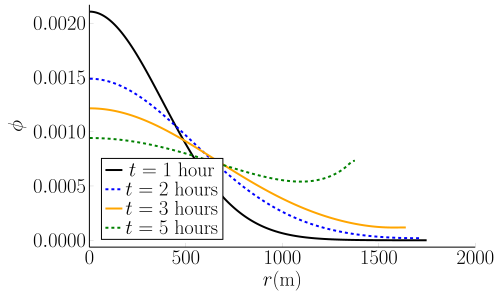

In [224]:
L = 2000
N = 1000
dx = div(L,N)
D = 200#5062.87
d = D/dx^2
u = zeros(N)
T = t_rt[end]
dt = 10.0#100.0
tD = 00.0

#IC is solution to diffusion equation at time T

x = dx:dx:L
u0 = zeros(size(x))
u0[1] = 1/dx


prior = [Uniform(2.5e6,4e6), Uniform(0.0,7.2e3)]
R_0 = 1755.6
t_s = 901
@time msds, u0s = domain_shrink([R_0,t_s],d,dt,u0,dt:dt:T,tD);

p1 = plot(xlabel=L"$r$(m)", ylabel=L"\phi", xlim=(0,2000))
i = 1
 plot!(dx:dx:length(u0s[Int(div(3600,dt))])*dx,u0s[Int(div(3600,dt))],label=L"$t=1$ hour",ls=ls[i],color=lc[i])
i = 2
    plot!(dx:dx:length(u0s[Int(div(3600*2,dt))])*dx,u0s[Int(div(3600*2,dt))],label=L"$t=2$ hours",ls=ls[i],color=lc[i])
i = 3
 plot!(dx:dx:length(u0s[Int(div(3600*3-1,dt))])*dx,u0s[Int(div(3600*3-1,dt))],label=L"$t=3$ hours",ls=ls[1],color=lc[i])
i = 5
 plot!(dx:dx:length(u0s[Int(div(3600*5,dt))])*dx,u0s[Int(div(3600*5,dt))],label=L"$t=5$ hours",ls=ls[2],color=lc[i])
plot!(     tickfontsize=20, guidefontsize=20, legendfontsize=20,legend=:bottomleft)
#savefig("../figs/shrinkphi_D200.png")


D = 20#5062.87
d = D/dx^2

@time msds, u0s = domain_shrink([R_0,t_s],d,dt,u0,dt:dt:T,tD);

p2 = plot(xlabel=L"$r$(m)", ylabel=L"\phi", xlim=(0,2000))
i = 1
 plot!(dx:dx:length(u0s[Int(div(3600,dt))])*dx,u0s[Int(div(3600,dt))],label=L"$t=1$ hour",ls=ls[i],color=lc[i])
i = 2
    plot!(dx:dx:length(u0s[Int(div(3600*2,dt))])*dx,u0s[Int(div(3600*2,dt))],label=L"$t=2$ hours",ls=ls[i],color=lc[i])
i = 3
 plot!(dx:dx:length(u0s[Int(div(3600*3-1,dt))])*dx,u0s[Int(div(3600*3-1,dt))],label=L"$t=3$ hours",ls=ls[1],color=lc[i])
i = 5
 plot!(dx:dx:length(u0s[Int(div(3600*5,dt))])*dx,u0s[Int(div(3600*5,dt))],label=L"$t=5$ hours",ls=ls[2],color=lc[i])
plot!(     tickfontsize=20, guidefontsize=20, legendfontsize=20,legend=:bottomleft)
#savefig("../figs/shrinkphi_D200.png")

In [170]:
@load "shrink_bound.jld2" t_rt msds 
t_s = t_rt
@load "radiotrack.jld2" t meansd semsd stdsd
t_rt = t 

600.0:600.0:28200.0

Plot comparison of convection-diffusion and shrinking domain with radiotracking data:

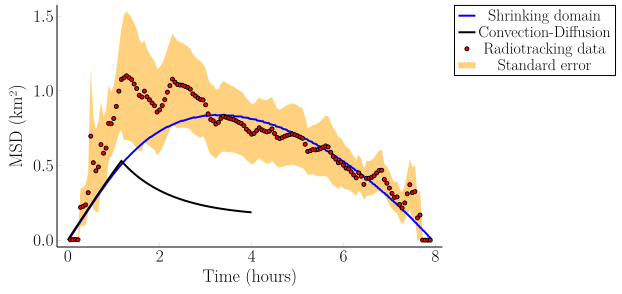

In [197]:
p1 = plot(xlabel="Time (hours)",ylabel="MSD (km²)")
plot!(t_s./3600,msds./1e6, color=:blue, label="Shrinking domain")
plot!(t_cd./3600, msd_cd./1e6, color=:black, label="Convection-Diffusion")
scatter!(t_rt./3600,msd_rt./1e6, color=:red, label="Radiotracking data")
plot!(t_rt./3600,msd_rt./1e6, ribbon=sem_rt./1e6, fill=:orange, linewidth=0,
    markersize=8, color=:orange, label="Standard error")
#savefig("../figs/msd_comparison.png")
plot(p1)

OLD DIFFUSION FUNCTIONS:

In [ ]:
function centreddiffusion2d!(du,u,p,t)
    D,h,n = p
    du[1] = (D/h^2)*(u[2]-u[1]) + (D/(2h^2))*(u[2]-u[1])
    for i = 2:n-1
        du[i] = (D/h^2)*(u[i-1]-2*u[i]+u[i+1]) + (D/(2i*h^2))*(u[i+1]-u[i-1])
    end
    du[n] = (D/h^2)*(u[n-1]-u[n]) + (D/(2n*h^2))*(u[n]-u[n-1])
end
    
function diffusion_sim2d(D, dt, u0, N, h, t, r)
    tspan = (0.0, dt)
    msd = [2*pi*sum(u0.*r.^3)]
    us_int = [2*pi*sum(r.*u0)]
    us = [u0]
    for (i,ts) in enumerate(t[1:(end-1)])
        prob = ODEProblem(centreddiffusion2d!,u0,tspan,(D,h,N))
        u0 = solve(prob, Euler(),dt=dt).u[end]
        append!(msd,2*pi*sum(u0.*r.^3))
        append!(us,[u0])
        append!(us_int,2*pi*sum(u0.*r))
    end
    return msd, us_int, us
end

function diffusions!(du,u,p,t)
    d,n = p
    du[1] = d*(u[2]-u[1])
    for i = 2:n-1
       du[i] = d*(u[i-1]-2*u[i]+u[i+1])
    end
    du[n] = d*(u[n-1]-u[n])
end


function diffusion_sim(d, dt, u0, N, t,x,dx)
    us = [u0]
    tspan = (0.0, dt)
    msd = [trapz(u0.*x.^2,dx)]
    for (i,ts) in enumerate(t[1:end-1])
        prob = ODEProblem(diffusions!,u0,tspan,(d,N))
        u0 = solve(prob).u[end]
        append!(msd,trapz(u0.*x.^2,dx))
        append!(us,[u0])
    end
    return msd, us
end